In [1]:
from data import colorize_image as CI
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

# Choose gpu to run the model on
gpu_id = -1

# Initialize colorization class
colorModel = CI.ColorizeImageCaffe(Xd=256)

# Load the model
colorModel.prep_net(gpu_id,'./models/reference_model/deploy_nodist.prototxt','./models/reference_model/model.caffemodel')

ColorizeImageCaffe instantiated
gpu_id = -1, net_path = ./models/reference_model/deploy_nodist.prototxt, model_path = ./models/reference_model/model.caffemodel


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import skimage.color as color
import scipy.ndimage.interpolation as sni
import caffe
import cv2

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 6)

In [4]:
# gpu_id = 0
# caffe.set_mode_gpu()
# caffe.set_device(gpu_id)

# Select desired model
net = caffe.Net('../../colorization/models/colorization_deploy_v2.prototxt', '../../colorization/models/colorization_release_v2.caffemodel', caffe.TEST)
# net = caffe.Net('../models/colorization_deploy_v2.prototxt', '../models/colorization_release_v2_norebal.caffemodel', caffe.TEST)
# net = caffe.Net('../models/colorization_deploy_v1.prototxt', '../models/colorization_release_v1.caffemodel', caffe.TEST)
# If you are training your own network, you may replace the *.caffemodel path with your trained network.

(H_in,W_in) = net.blobs['data_l'].data.shape[2:] # get input shape
(H_out,W_out) = net.blobs['class8_ab'].data.shape[2:] # get output shape

print 'Input dimensions: (%i,%i)'%(H_in,W_in)
print 'Output dimensions: (%i,%i)'%(H_out,W_out)

Input dimensions: (224,224)
Output dimensions: (56,56)


In [4]:
pts_in_hull = np.load('../../colorization/resources/pts_in_hull.npy') # load cluster centers
net.params['class8_ab'][0].data[:,:,0,0] = pts_in_hull.transpose((1,0)) # populate cluster centers as 1x1 convolution kernel
# print 'Annealed-Mean Parameters populated'

In [21]:
color_folder = './number_of_points_performance/input_images/'
bw_folder = './number_of_points_performance/input_images_bw/'
output_combined = './number_of_points_performance/output_combined/'

In [23]:
# read path of all images to a list
folder = color_folder
images = []
for filename in os.listdir(folder):
    images.append(filename)
images

['aeroplane.jpg', 'boys.jpg', 'car.jpg', 'car_boys.jpg', 'horse.jpg']

In [24]:
# make black and white images
# load the colored image
i=0
for my_image in images:
    i=i+1
    print(str(i) + ". processing: "+my_image)
    img_rgb = caffe.io.load_image(color_folder + my_image)
    img_lab = color.rgb2lab(img_rgb) # convert image to lab color space
    img_l = img_lab[:,:,0] # pull out L channel
    plt.imsave(bw_folder + my_image, img_l, cmap='gray') # save image

1. processing: aeroplane.jpg
2. processing: boys.jpg
3. processing: car.jpg
4. processing: car_boys.jpg
5. processing: horse.jpg


In [25]:
%matplotlib inline
# code to run on batch of images
cnt=0
for my_image in images:
    cnt=cnt+1
    print(str(cnt) + ". processing: "+my_image)
    
        
    # load the original image
    img_rgb = caffe.io.load_image(color_folder + my_image)

    img_lab = color.rgb2lab(img_rgb) # convert image to lab color space
    img_l = img_lab[:,:,0] # pull out L channel
    (H_orig,W_orig) = img_rgb.shape[:2] # original image size

    # create grayscale version of image (just for displaying)
    img_lab_bw = img_lab.copy()
    img_lab_bw[:,:,1:] = 0
    img_rgb_bw = color.lab2rgb(img_lab_bw)

    # resize image to network input size
    img_rs = caffe.io.resize_image(img_rgb,(H_in,W_in)) # resize image to network input size
    img_lab_rs = color.rgb2lab(img_rs)
    img_l_rs = img_lab_rs[:,:,0]

    # show original image, along with grayscale input to the network
    img_pad = np.ones((H_orig,W_orig/10,3))




    net.blobs['data_l'].data[0,0,:,:] = img_l_rs-50 # subtract 50 for mean-centering
    net.forward() # run network

    ab_dec = net.blobs['class8_ab'].data[0,:,:,:].transpose((1,2,0)) # this is our result
    ab_dec_us = sni.zoom(ab_dec,(1.*H_orig/H_out,1.*W_orig/W_out,1)) # upsample to match size of original image L
    img_lab_out = np.concatenate((img_l[:,:,np.newaxis],ab_dec_us),axis=2) # concatenate with original image L
    img_rgb_out = (255*np.clip(color.lab2rgb(img_lab_out),0,1)).astype('uint8') # convert back to rgb


#     plt.imsave('wallpapers_output_orig/' + my_image, img_rgb_out)

    # Load the image
    # colorModel.load_image('./test_imgs/mortar_pestle.jpg') # load an image
    colorModel.load_image(bw_folder + my_image)


    mask = np.zeros((1,256,256)) # giving no user points, so mask is all 0's
    input_ab = np.zeros((2,256,256)) # ab values of user points, default to 0 for no input
    img_out = colorModel.net_forward(input_ab,mask) # run model, returns 256x256 image

    img_gray_fullres = colorModel.get_img_gray_fullres() # get grayscale image at fullresolution
    img_out_fullres = colorModel.get_img_fullres() # get image at full resolution

#     plt.imsave('wallpapers_output_default/' + my_image, img_out_fullres)

    # predict for different number of pixels
    for gap in [25, 50, 100, 150, 175, 200]:
        print("gap = " + str(gap))
        
        # initialize with no user inputs
        input_ab = np.zeros((2,256,256))
        mask = np.zeros((1,256,256))

        ab_my = sni.zoom(ab_dec,(1.*256/H_out,1.*256/W_out,1))

#         input_my=np.zeros((2,256,256))
#         input_my[0,:,:] = ab_my[:,:,0]
#         input_my[1,:,:] = ab_my[:,:,1]

        # creating mask
        for i in range(5,255,gap):
            for j in range(5,255,gap):
                (input_ab,mask) = put_point(input_ab,mask,[i,j],3,[ab_my[i,j,0],ab_my[i,j,1]])

    #     for i in range(10):
    #         x = np.random.randint(10,255)
    #         y = np.random.randint(10,255)
    #         (input_ab,mask) = put_point(input_ab,mask,[x,y],3,[ab_my[x,y,0],ab_my[x,y,1]])


        # call forward
        img_out = colorModel.net_forward(input_ab,mask)

        # get mask, input image, and result in full resolution
        mask_fullres = colorModel.get_img_mask_fullres() # get input mask in full res
        img_in_fullres = colorModel.get_input_img_fullres() # get input image in full res
        img_out_fullres = colorModel.get_img_fullres() # get image at full resolution

        plt.imsave(output_combined + str(gap) + my_image, img_out_fullres)




1. processing: aeroplane.jpg


/home/gg_14/anaconda3/envs/imageColorization2/lib/python2.7/site-packages/scipy/ndimage/interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


gap = 25
gap = 50
gap = 100
gap = 150
gap = 175
gap = 200
2. processing: boys.jpg
gap = 25
gap = 50
gap = 100
gap = 150
gap = 175
gap = 200
3. processing: car.jpg
gap = 25
gap = 50
gap = 100
gap = 150
gap = 175
gap = 200
4. processing: car_boys.jpg
gap = 25
gap = 50
gap = 100
gap = 150
gap = 175
gap = 200
5. processing: horse.jpg
gap = 25
gap = 50
gap = 100
gap = 150
gap = 175
gap = 200


In [65]:
my_image = './imgs/scenary.jpg'

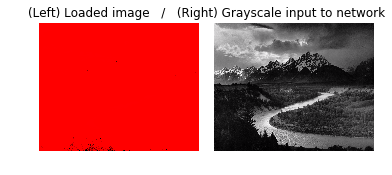

In [66]:
%matplotlib inline
# load the original image
img_rgb = caffe.io.load_image(my_image)

img_lab = color.rgb2lab(img_rgb) # convert image to lab color space
img_l = img_lab[:,:,0] # pull out L channel
(H_orig,W_orig) = img_rgb.shape[:2] # original image size

# create grayscale version of image (just for displaying)
img_lab_bw = img_lab.copy()
img_lab_bw[:,:,1:] = 0
img_rgb_bw = color.lab2rgb(img_lab_bw)

# resize image to network input size
img_rs = caffe.io.resize_image(img_rgb,(H_in,W_in)) # resize image to network input size
img_lab_rs = color.rgb2lab(img_rs)
img_l_rs = img_lab_rs[:,:,0]

# show original image, along with grayscale input to the network
img_pad = np.ones((H_orig,W_orig/10,3))
# plt.imshow(img_lab)
plt.imshow(np.hstack((img_lab, img_pad, img_rgb_bw)))
plt.title('(Left) Loaded image   /   (Right) Grayscale input to network')
plt.axis('off');

In [5]:
net.blobs['data_l'].data[0,0,:,:] = img_l_rs-50 # subtract 50 for mean-centering
net.forward() # run network

ab_dec = net.blobs['class8_ab'].data[0,:,:,:].transpose((1,2,0)) # this is our result
ab_dec_us = sni.zoom(ab_dec,(1.*H_orig/H_out,1.*W_orig/W_out,1)) # upsample to match size of original image L
img_lab_out = np.concatenate((img_l[:,:,np.newaxis],ab_dec_us),axis=2) # concatenate with original image L
img_rgb_out = (255*np.clip(color.lab2rgb(img_lab_out),0,1)).astype('uint8') # convert back to rgb

plt.imshow(img_rgb_out)
plt.axis('off');

NameError: name 'img_l_rs' is not defined

In [6]:
# Load the image
# colorModel.load_image('./test_imgs/mortar_pestle.jpg') # load an image
colorModel.load_image('./test_imgs/scenary.jpg')

/home/gg_14/anaconda3/envs/imageColorization2/lib/python2.7/site-packages/scipy/ndimage/interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


In [16]:
def put_point(input_ab,mask,loc,p,val):
    # input_ab    2x256x256    current user ab input (will be updated)
    # mask        1x256x256    binary mask of current user input (will be updated)
    # loc         2 tuple      (h,w) of where to put the user input
    # p           scalar       half-patch size
    # val         2 tuple      (a,b) value of user input
    input_ab[:,loc[0]-p:loc[0]+p+1,loc[1]-p:loc[1]+p+1] = np.array(val)[:,np.newaxis,np.newaxis]
    mask[:,loc[0]-p:loc[0]+p+1,loc[1]-p:loc[1]+p+1] = 1
    return (input_ab,mask)

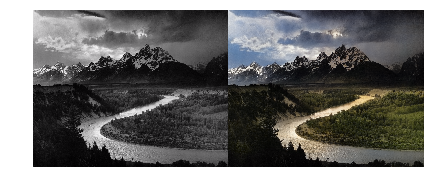

In [70]:
mask = np.zeros((1,256,256)) # giving no user points, so mask is all 0's
input_ab = np.zeros((2,256,256)) # ab values of user points, default to 0 for no input
img_out = colorModel.net_forward(input_ab,mask) # run model, returns 256x256 image

img_gray_fullres = colorModel.get_img_gray_fullres() # get grayscale image at fullresolution
img_out_fullres = colorModel.get_img_fullres() # get image at full resolution

# show result
plt.figure(figsize=(7,3))
plt.imshow(np.concatenate((img_gray_fullres,img_out_fullres),axis=1)); plt.axis('off');
plt.imsave('./test_imgs/out.jpg',img_out_fullres)

(2, 256, 256)
(1, 256, 256)


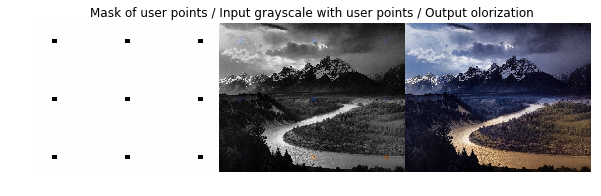

In [72]:
# %matplotlib qt
# initialize with no user inputs
input_ab = np.zeros((2,256,256))
mask = np.zeros((1,256,256))

# add a blue point in the middle of the image
# (input_ab,mask) = put_point(input_ab,mask,[142,160],3,[1,0]) # horse gray
# (input_ab,mask) = put_point(input_ab,mask,[135,90],3,[63,52]) # red bus
# (input_ab,mask) = put_point(input_ab,mask,[50,150],3,[-25,-21]) # blue sky
# (input_ab,mask) = put_point(input_ab,mask,[160,210],3,[21,45]) # brown building
# (input_ab,mask) = put_point(input_ab,mask,[90,90],3,[6,77]) # yellow umbrella
# print(input_ab.shape)
# print(mask.shape)

ab_my = sni.zoom(ab_dec,(1.*256/H_out,1.*256/W_out,1))

input_my=np.zeros((2,256,256))
input_my[0,:,:] = ab_my[:,:,0]
input_my[1,:,:] = ab_my[:,:,1]

# mask[:,:,:] = 0

# creating mask
for i in range(30,255,100):
    for j in range(30,255,100):
#         mask[0,i,j] = 1
#         (input_my,mask) = put_point(input_my,mask,[i,j],3,[ab_my[i,j,0],ab_my[i,j,1]])
        (input_ab,mask) = put_point(input_ab,mask,[i,j],3,[ab_my[i,j,0],ab_my[i,j,1]])

# for i in range(10):
#     x = np.random.randint(10,255)
#     y = np.random.randint(10,255)
#     (input_ab,mask) = put_point(input_ab,mask,[x,y],3,[ab_my[x,y,0],ab_my[x,y,1]])




# input_ab = ab_dec

print(input_ab.shape)
print(mask.shape)
# call forward
img_out = colorModel.net_forward(input_ab,mask)

# get mask, input image, and result in full resolution
mask_fullres = colorModel.get_img_mask_fullres() # get input mask in full res
img_in_fullres = colorModel.get_input_img_fullres() # get input image in full res
img_out_fullres = colorModel.get_img_fullres() # get image at full resolution

# show user input, along with output
plt.figure(figsize=(10,6))
plt.imshow(np.concatenate((mask_fullres,img_in_fullres,img_out_fullres),axis=1));
plt.title('Mask of user points / Input grayscale with user points / Output olorization')
plt.imsave('./scenary_out.jpg',img_out_fullres)
plt.axis('off');

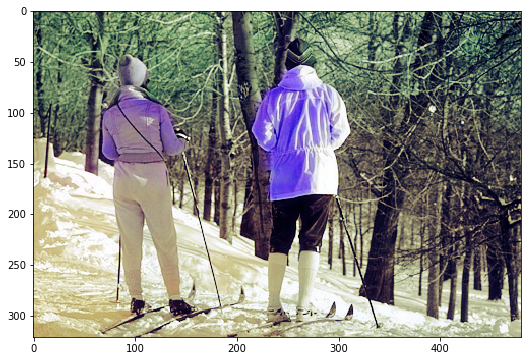

In [11]:
# increase contrast of image (using histogram equalization)
# 92014
img = cv2.imread('./my_output/277053.jpg')
for c in xrange(0,2):
    img[:,:,c] = cv2.equalizeHist(img[:,:,c])
# f_img = cv2.cvtColor(img_to_yuv, cv2.COLOR_YUV2BGR)
plt.imshow(img)

In [4]:
cv2.imread?